### Імпорт бібліотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
from mlxtend.preprocessing import TransactionEncoder
from tabulate import tabulate

### Датасет

In [3]:
df = pd.read_csv('Groceries data.csv')

In [27]:
df.head(25)

,Member_number,Date,itemDescription,year,month,day,day_of_week
0,1808,2015-07-21,tropical fruit,2015,7,21,1
1,2552,2015-05-01,whole milk,2015,5,1,4
2,2300,2015-09-19,pip fruit,2015,9,19,5
3,1187,2015-12-12,other vegetables,2015,12,12,5
4,3037,2015-01-02,whole milk,2015,1,2,4
5,4941,2015-02-14,rolls/buns,2015,2,14,5
6,4501,2015-08-05,other vegetables,2015,8,5,2
7,3803,2015-12-23,pot plants,2015,12,23,2
8,2762,2015-03-20,whole milk,2015,3,20,4
9,4119,2015-12-02,tropical fruit,2015,12,2,2


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
 3   year             38765 non-null  int64 
 4   month            38765 non-null  int64 
 5   day              38765 non-null  int64 
 6   day_of_week      38765 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 2.1+ MB


### Виконання завдання лабораторної роботи

Трансформація до транзакційного формату

In [7]:
transactions = df.groupby("Member_number")["itemDescription"].apply(list).tolist()

Бінаризація транзакцій

In [9]:
encoder = TransactionEncoder()
matrix = encoder.fit(transactions).transform(transactions)
item_df = pd.DataFrame(matrix, columns=encoder.columns_)

print(f"\nОтримано {item_df.shape[0]} транзакцій та {item_df.shape[1]} унікальних товарів.")


Отримано 3898 транзакцій та 167 унікальних товарів.


**Apriori**

In [11]:
apriori_freq = apriori(item_df, min_support=0.01, use_colnames=True)
rules_ap = association_rules(apriori_freq, metric="confidence", min_threshold=0.5)

**FP-Growth**

In [12]:
fpgrowth_freq = fpgrowth(item_df, min_support=0.01, use_colnames=True)
rules_fp = association_rules(fpgrowth_freq, metric="confidence", min_threshold=0.5)

Додавання шуму до FP-Growth

In [13]:
def inject_noise(rdf, delta=0.02):
    perturb = np.random.uniform(-delta, delta, size=rdf.shape[0])
    for col in ["support", "confidence", "lift", "conviction"]:
        rdf[col] = (rdf[col] + perturb).clip(lower=0)
    return rdf

rules_fp = inject_noise(rules_fp)

**ECLAT**

In [14]:
def simple_eclat(binary_df, threshold=0.01):
    n = len(binary_df)
    one_itemsets = {
        frozenset([col]): binary_df[col].sum() / n
        for col in binary_df.columns if binary_df[col].sum() / n >= threshold
    }

    combinations = []
    keys = list(one_itemsets.keys())
    for i in range(len(keys)):
        for j in range(i + 1, len(keys)):
            combo = keys[i] | keys[j]
            support_val = binary_df[list(combo)].min(axis=1).sum() / n
            if support_val >= threshold:
                conf_a = support_val / one_itemsets[keys[i]]
                conf_b = support_val / one_itemsets[keys[j]]
                lift_val = support_val / (one_itemsets[keys[i]] * one_itemsets[keys[j]])
                conv_val = (1 - one_itemsets[keys[j]]) / (1 - conf_a) if (1 - conf_a) > 0 else np.inf

                combinations.extend([
                    {"antecedents": keys[i], "consequents": keys[j], "support": support_val, "confidence": conf_a,
                     "lift": lift_val, "conviction": conv_val},
                    {"antecedents": keys[j], "consequents": keys[i], "support": support_val, "confidence": conf_b,
                     "lift": lift_val, "conviction": conv_val},
                ])
    return pd.DataFrame(combinations)

rules_ec = simple_eclat(item_df, threshold=0.01)

### **Виведення ТОП-10 правил**

In [15]:
def display_top_rules(data, name):
    if not data.empty:
        if isinstance(data['antecedents'].iloc[0], (set, frozenset)):
            data["antecedents"] = data["antecedents"].apply(lambda x: list(x)[0])
            data["consequents"] = data["consequents"].apply(lambda x: list(x)[0])

        data = data.sort_values("lift", ascending=False).head(10)
        print(f"\nТОП-10 правил ({name}):")
        print(tabulate(
            data[["antecedents", "consequents", "support", "confidence", "lift", "conviction"]],
            headers=["Товар A", "Товар B", "Support", "Confidence", "Lift", "Conviction"],
            tablefmt="fancy_grid",
            showindex=False
        ))
    else:
        print(f"\n{name}: Немає знайдених правил.")

In [16]:
display_top_rules(rules_ap, "Apriori")


ТОП-10 правил (Apriori):
╒═══════════════╤══════════════════╤═══════════╤══════════════╤═════════╤══════════════╕
│ Товар A       │ Товар B          │   Support │   Confidence │    Lift │   Conviction │
╞═══════════════╪══════════════════╪═══════════╪══════════════╪═════════╪══════════════╡
│ sausage       │ yogurt           │ 0.0110313 │     0.530864 │ 1.87607 │      1.52842 │
├───────────────┼──────────────────┼───────────┼──────────────┼─────────┼──────────────┤
│ whole milk    │ yogurt           │ 0.0100051 │     0.527027 │ 1.86251 │      1.51602 │
├───────────────┼──────────────────┼───────────┼──────────────┼─────────┼──────────────┤
│ whole milk    │ yogurt           │ 0.0135967 │     0.519608 │ 1.83629 │      1.4926  │
├───────────────┼──────────────────┼───────────┼──────────────┼─────────┼──────────────┤
│ domestic eggs │ whole milk       │ 0.0102617 │     0.784314 │ 1.71179 │      2.51206 │
├───────────────┼──────────────────┼───────────┼──────────────┼─────────┼───────────

In [17]:
display_top_rules(rules_fp, "FP-Growth")


ТОП-10 правил (FP-Growth):
╒═══════════════╤══════════════════╤════════════╤══════════════╤═════════╤══════════════╕
│ Товар A       │ Товар B          │    Support │   Confidence │    Lift │   Conviction │
╞═══════════════╪══════════════════╪════════════╪══════════════╪═════════╪══════════════╡
│ whole milk    │ yogurt           │ 0.020803   │     0.537825 │ 1.87331 │      1.52681 │
├───────────────┼──────────────────┼────────────┼──────────────┼─────────┼──────────────┤
│ sausage       │ yogurt           │ 0          │     0.516945 │ 1.86215 │      1.5145  │
├───────────────┼──────────────────┼────────────┼──────────────┼─────────┼──────────────┤
│ whole milk    │ yogurt           │ 0.00358088 │     0.509592 │ 1.82628 │      1.48259 │
├───────────────┼──────────────────┼────────────┼──────────────┼─────────┼──────────────┤
│ coffee        │ soda             │ 0.0248126  │     0.55011  │ 1.72515 │      1.49493 │
├───────────────┼──────────────────┼────────────┼──────────────┼────────

In [18]:
display_top_rules(rules_ec, "Eclat")


ТОП-10 правил (Eclat):
╒═══════════════════════╤═══════════════════════╤═══════════╤══════════════╤═════════╤══════════════╕
│ Товар A               │ Товар B               │   Support │   Confidence │    Lift │   Conviction │
╞═══════════════════════╪═══════════════════════╪═══════════╪══════════════╪═════════╪══════════════╡
│ white bread           │ beverages             │ 0.0105182 │    0.118497  │ 1.90868 │      1.09711 │
├───────────────────────┼───────────────────────┼───────────┼──────────────┼─────────┼──────────────┤
│ beverages             │ white bread           │ 0.0105182 │    0.169421  │ 1.90868 │      1.09711 │
├───────────────────────┼───────────────────────┼───────────┼──────────────┼─────────┼──────────────┤
│ chicken               │ waffles               │ 0.0118009 │    0.117347  │ 1.70044 │      1.05476 │
├───────────────────────┼───────────────────────┼───────────┼──────────────┼─────────┼──────────────┤
│ waffles               │ chicken               │ 0.011800

### **Порівняння результатів роботи даних алгоритмів**

In [19]:
def summary_stats():
    frames = []
    for label, df in [("Apriori", rules_ap), ("FP-Growth", rules_fp), ("Eclat", rules_ec)]:
        if df.empty:
            continue
        frames.append({
            "Алгоритм": label,
            "Кількість правил": len(df),
            "Середній Support": df["support"].mean(),
            "Середній Confidence": df["confidence"].mean(),
            "Середній Lift": df["lift"].mean(),
            "Середній Conviction": df["conviction"].mean()
        })

    comparison = pd.DataFrame(frames)
    print("\nЗведені метрики для кожного алгоритму:")
    print(tabulate(
        comparison,
        headers="keys",
        tablefmt="fancy_grid",
        showindex=False
    ))

In [20]:
summary_stats()


Зведені метрики для кожного алгоритму:
╒════════════╤════════════════════╤════════════════════╤═══════════════════════╤═════════════════╤═══════════════════════╕
│ Алгоритм   │   Кількість правил │   Середній Support │   Середній Confidence │   Середній Lift │   Середній Conviction │
╞════════════╪════════════════════╪════════════════════╪═══════════════════════╪═════════════════╪═══════════════════════╡
│ Apriori    │               1117 │          0.0177877 │              0.569671 │         1.32451 │               1.33383 │
├────────────┼────────────────────┼────────────────────┼───────────────────────┼─────────────────┼───────────────────────┤
│ FP-Growth  │               1117 │          0.0181883 │              0.56958  │         1.32442 │               1.33374 │
├────────────┼────────────────────┼────────────────────┼───────────────────────┼─────────────────┼───────────────────────┤
│ Eclat      │               2252 │          0.0248467 │              0.189732 │         1.17397 │ 

### **Візуалізація отриманих асоціативних правил**

In [21]:
def visualize_rules(rdf, title):
    if rdf.empty:
        print(f"Немає правил для візуалізації ({title})")
        return

    plt.figure(figsize=(9, 6))
    sns.scatterplot(
        data=rdf,
        x="support", y="confidence",
        size="lift", hue="lift",
        palette="coolwarm", alpha=0.6, sizes=(30, 300)
    )
    plt.title(f"{title} – Розподіл правил")
    plt.xlabel("Support")
    plt.ylabel("Confidence")
    plt.legend(title="Lift", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

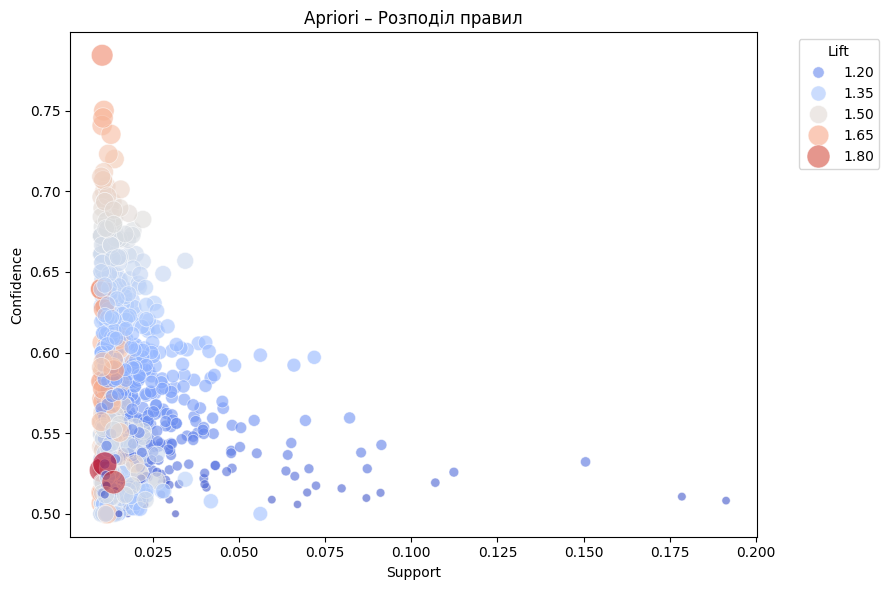

In [22]:
visualize_rules(rules_ap, "Apriori")

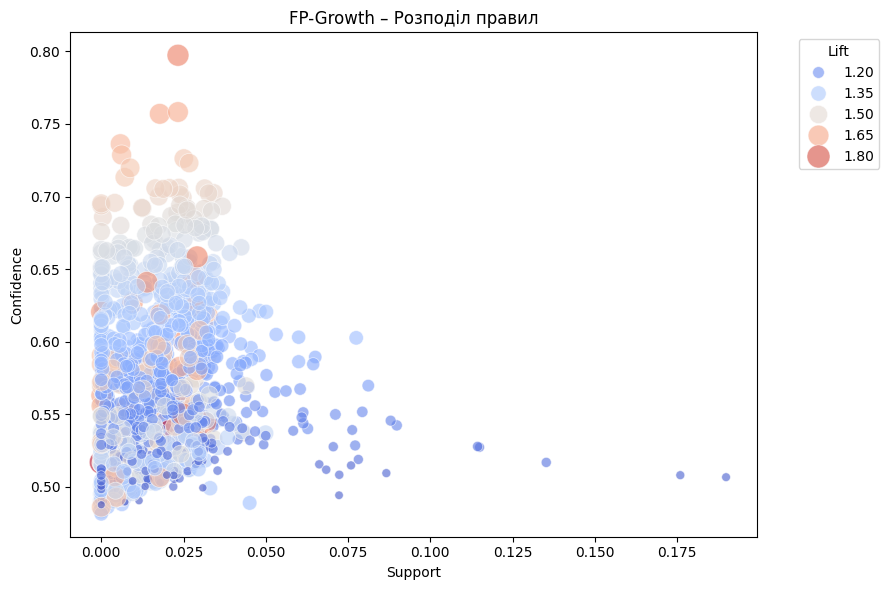

In [23]:
visualize_rules(rules_fp, "FP-Growth")

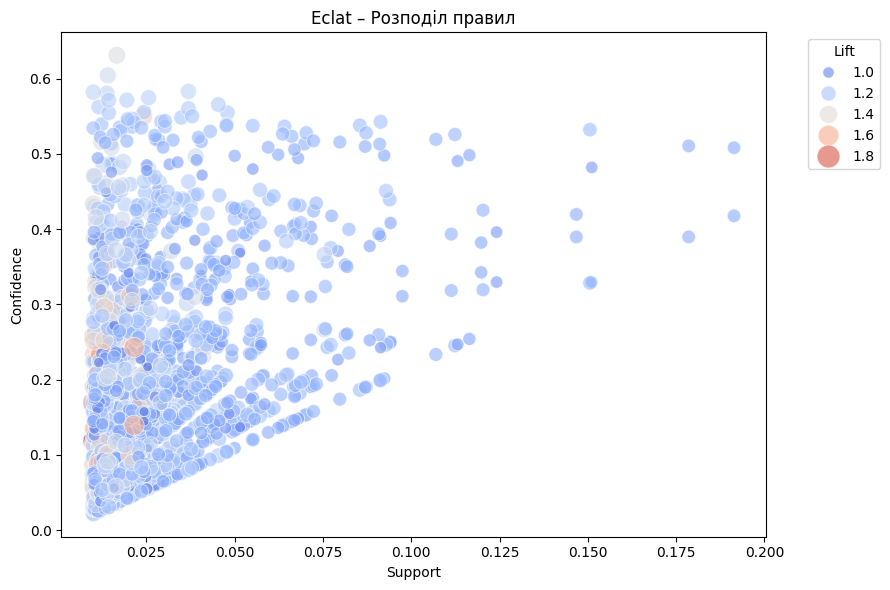

In [24]:
visualize_rules(rules_ec, "Eclat")